In [1]:
from obspy import read, Trace, UTCDateTime
import glob, os, re
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np 
from scipy.fft import fft, fftfreq, rfft
from scipy.io.wavfile import read as wavread

def calib(data, S):
    return data / ((10)**(S/20))
def readwav(path, S):
    rate, data = wavread(path)
    data = data.astype(np.float32, order='C') / 32768.0
    data = calib(data, S)
    
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    date = path.rsplit('.')[1]
    tr.stats.starttime = UTCDateTime(f'20{date[:12]}')
    tr.decimate(5, no_filter=True)
    # print(trslice.stats.statttime)
    # tr = tr.filter('bandpass', freqmin=500, freqmax=6000, corners=4, zerophase=True)
    return tr

In [2]:
path = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav/6979.230616090002.wav'
rate, data = wavread(path)

data = data.astype(np.float32, order='C') / 32768.0
data = calib(data, -176.1)

tr = Trace()
tr.data = data
tr.stats.sampling_rate = rate
tr.stats.starttime = UTCDateTime(2023,6,16,9,0,2)

In [193]:
begin = tr.stats.starttime+5*60
end = begin+5*60
tr_slice = tr.slice(begin,end)
tr_slice.detrend('linear')
tr_slice.detrend('demean')

... | 2023-06-16T09:05:02.000000Z - 2023-06-16T09:10:02.000000Z | 96000.0 Hz, 28800001 samples

In [11]:
!ls /Volumes/home/Research/Detect_fish/Taoyuan_fishcall_grunt/msd

230414 230416 230608 230610 230612 230614 230616 230618 230620 230622
230415 230417 230609 230611 230613 230615 230617 230619 230621 230623


In [16]:
path = '/Volumes/home/Research/Detect_fish/Taoyuan_fishcall_grunt/msd/230617/230617_201711.mseed'
tr = read(path)[0]
tr_slice = tr.filter('bandpass', freqmin=100, freqmax=2000, corners=4, zerophase=True)

env_tr=Trace()
env_tr.data = abs(signal.hilbert(tr_slice.data))
env_tr.stats.sampling_rate = rate

# calculate decimation rate
n = int((rate / (1000 * 2)))

env_tr.decimate(factor=n, no_filter=True)

# square root of signal
env_tr.data = np.sqrt(env_tr.data)
env_tr.detrend('demean')

avg_env = np.sqrt(1/len(env_tr.data)*np.sum(env_tr.data**2))
print(avg_env)

382.89538224155456


(0.0, 0.26166666666666666)

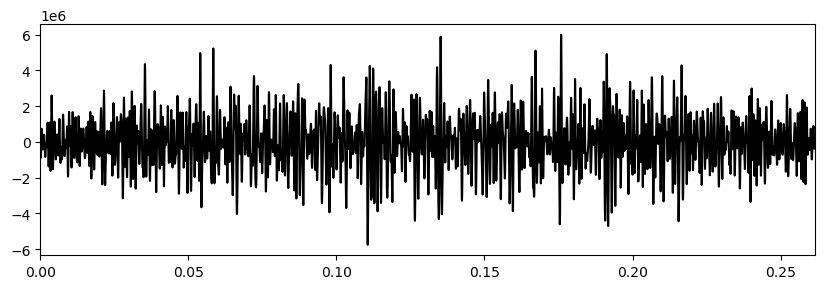

In [17]:
plt.figure(figsize=(10,3))
# plt.plot(env_tr.times()*1000, env_tr.data, 'grey', lw=1)
plt.plot(tr_slice.times(), tr_slice.data, 'k')

plt.xlim(tr_slice.times()[0], tr_slice.times()[-1])



In [18]:

freq =  np.linspace(0, tr_slice.stats.sampling_rate/2, len(tr_slice.data)//2+1)
env_freq =  np.linspace(0, env_tr.stats.sampling_rate/2, len(env_tr.data)//2+1)

tr_fft = rfft(tr_slice.data)
env_fft = rfft(env_tr.data)

peaks, properties = signal.find_peaks(abs(env_fft), height=0.2*10**np.log10(max(abs(env_fft))), )

print(len(peaks))

17


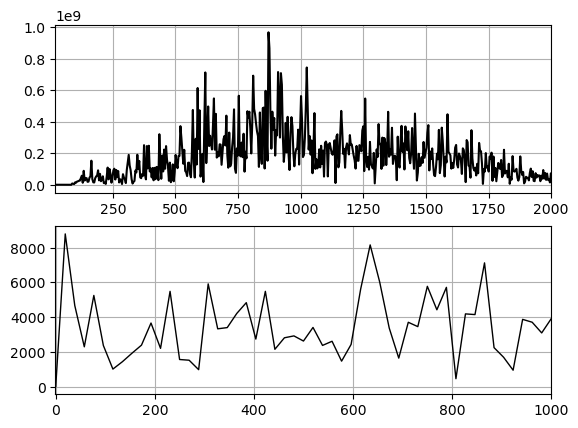

In [24]:
plt.subplot(211)
plt.plot(freq,  abs(tr_fft),'k')
plt.xlim(20,2000)
plt.grid()

plt.subplot(212)
# plt.scatter(env_freq[peaks], abs(env_fft)[peaks], marker='x', color='red')
plt.plot(env_freq,abs(env_fft),'k', lw=1)
plt.xlim(-1,1000)
# plt.xscale('log')
plt.grid()